In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import numpy as np
from dataclasses import dataclass
# --- Configuration ---

@dataclass
class Config:
        obs_dim = 2
        latent_dim = 4
        num_vars = 2
        codebook_size = 2
        num_levels = 3
        n_samples = 1000
        batch_size = 32
        epochs = 50
        lr = 1e-3
        curiosity_weight = 0.1
        lambda_1 = 1.0
        lambda_2 = 0.1

# --- Fractal Encoder ---
class FractalEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_levels=3):
        super().__init__()
        self.num_levels = num_levels
        self.layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else latent_dim, latent_dim)
            for i in range(num_levels)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(latent_dim) for _ in range(num_levels)])
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim if i == 0 else latent_dim, latent_dim),
                nn.GELU()
            ) for i in range(num_levels)
        ])

    def forward(self, x):
        for i in range(self.num_levels):
            fx = self.norms[i](self.layers[i](x))
            gx = self.gates[i](x)
            x = F.gelu(fx + gx)
        return x

# --- Meta-State Codebook ---
class MetaStateCodebook(nn.Module):
    def __init__(self, latent_dim, codebook_size):
        super().__init__()
        self.embedding = nn.Parameter(torch.randn(codebook_size, latent_dim) * 0.1)

    def forward(self, z):
        dists = torch.cdist(z, self.embedding)
        indices = dists.argmin(dim=-1)
        codes = self.embedding[indices]
        return codes, indices

# --- Causal Decoder ---
class CausalDecoder(nn.Module):
    def __init__(self, latent_dim, num_vars):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.GELU(),
            nn.Linear(64, num_vars * num_vars),
            nn.Sigmoid()
        )
        self.num_vars = num_vars

    def forward(self, meta_embedding):
        logits = self.decoder(meta_embedding)
        return logits.view(-1, self.num_vars, self.num_vars)

# --- Curious Causal Agent ---
class CuriousCausalAgent(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = FractalEncoder(config.obs_dim, config.latent_dim, config.num_levels)
        self.codebook = MetaStateCodebook(config.latent_dim, config.codebook_size)
        self.decoder = CausalDecoder(config.latent_dim, config.num_vars)

    def forward(self, x):
        z = self.encoder(x)
        meta_emb, meta_idx = self.codebook(z)
        causal_mask_logits = self.decoder(meta_emb)
        return causal_mask_logits, meta_idx, z

# --- Curiosity and Loss ---
def intervention_reward(mask_logits):
    entropy = -torch.sum(mask_logits * torch.log(mask_logits.clamp(min=1e-8)), dim=[1, 2])
    return entropy.mean()

def causal_loss(mask_logits, delta_matrix, lambda_1=1.0, lambda_2=0.1):
    pos = delta_matrix > 0
    neg = delta_matrix <= 0
    log_mask = torch.log(mask_logits.clamp(min=1e-8))
    log_1_minus = torch.log((1 - mask_logits).clamp(min=1e-8))
    loss = -lambda_1 * log_mask[pos].sum() - lambda_2 * log_1_minus[neg].sum()
    return loss / mask_logits.size(0)

# --- Door Dataset ---
class DoorDataset(Dataset):
    def __init__(self, n=1000):
        self.x = []
        self.delta = []
        for _ in range(n):
            locked = torch.randint(0, 2, (1,)).item()
            push_strength = torch.randn(1) * 0.5 + 1.0
            noise = torch.randn(1) * 0.1
            state = torch.tensor([push_strength.item(), locked + noise.item()])
            delta = torch.tensor([[0, 0], [1, 0]], dtype=torch.float32) if locked == 0 else torch.zeros((2, 2), dtype=torch.float32)
            self.x.append(state)
            self.delta.append(delta)
        self.x = torch.stack(self.x)
        self.delta = torch.stack(self.delta)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.delta[idx]

# --- Visualizer ---
def visualize_latents(embeddings, labels, title="Latent Space"):
    z_np = embeddings.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    if z_np.shape[1] > 2:
        pca = PCA(n_components=2)
        z_np = pca.fit_transform(z_np)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=z_np[:, 0], y=z_np[:, 1], hue=labels_np, palette='viridis', s=80, edgecolor='black', alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.legend(title="Meta-State", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# --- Training Loop ---
def train():
    config = Config()
    agent = CuriousCausalAgent(config)
    optimizer = torch.optim.AdamW(agent.parameters(), lr=config.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    dataset = DoorDataset(n=config.n_samples)
    loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    for epoch in range(config.epochs):
        agent.train()
        total_train_loss = 0
        for x, delta in loader:
            optimizer.zero_grad()
            mask_logits, _, _ = agent(x)
            curiosity = intervention_reward(mask_logits)
            loss = causal_loss(mask_logits, delta, config.lambda_1, config.lambda_2)
            total_loss = loss - config.curiosity_weight * curiosity
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.parameters(), 1.0)
            optimizer.step()
            total_train_loss += total_loss.item()

        scheduler.step()

        if epoch % 5 == 0 or epoch == config.epochs - 1:
            agent.eval()
            with torch.no_grad():
                z = agent.encoder(dataset.x)
                _, meta_ids = agent.codebook(z)
                print(f"Epoch {epoch}: Loss = {total_train_loss / len(loader):.4f}, LR = {scheduler.get_last_lr()[0]:.6f}")
                visualize_latents(z, meta_ids, title=f"Latent Space at Epoch {epoch}")

Epoch 0: Loss = 0.3494, LR = 0.000999


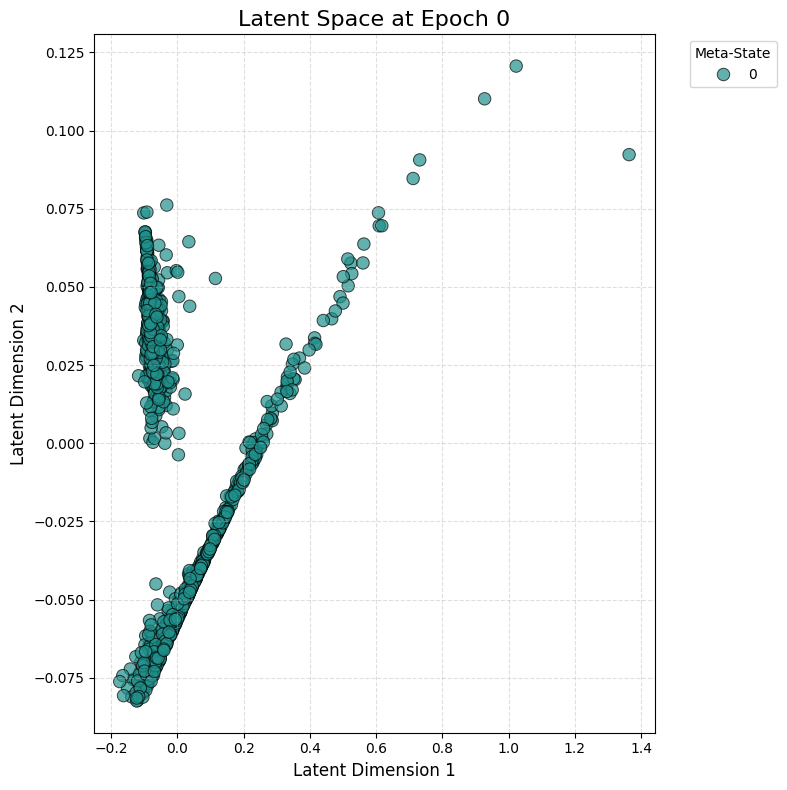

Epoch 5: Loss = 0.1217, LR = 0.000965


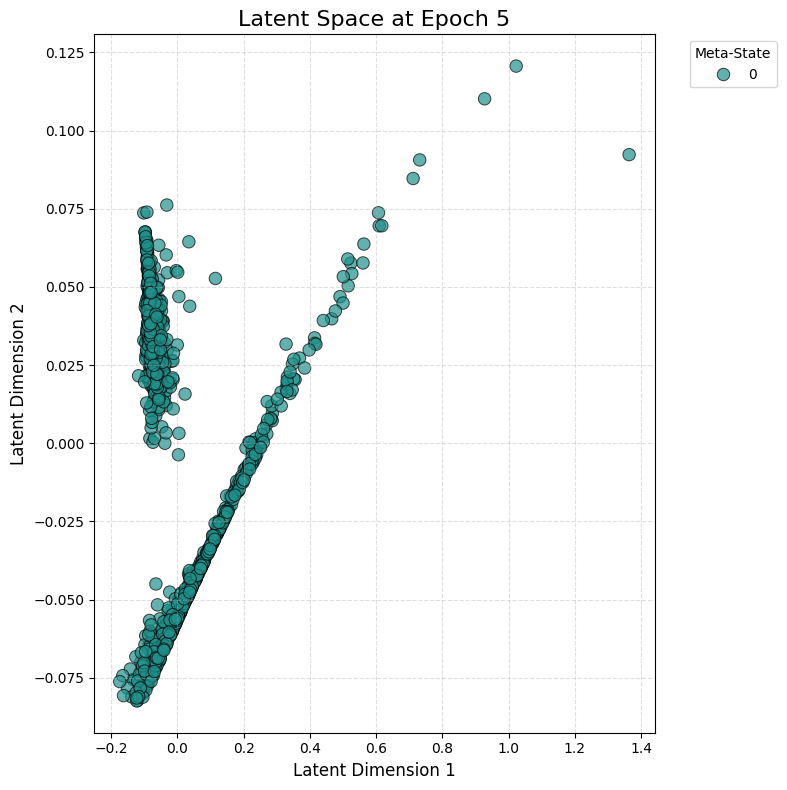

Epoch 10: Loss = 0.1213, LR = 0.000885


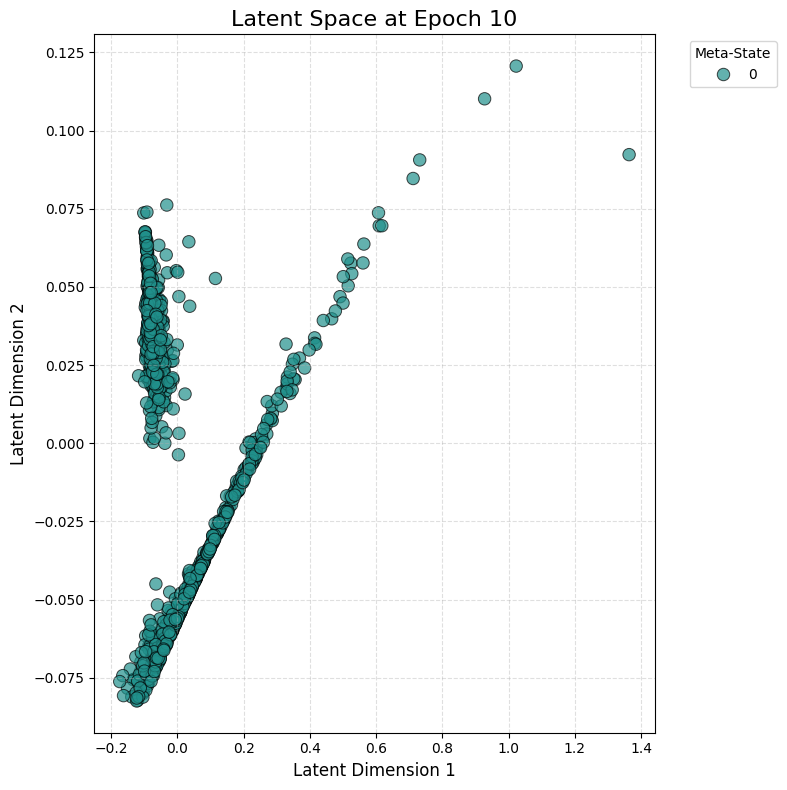

Epoch 15: Loss = 0.1210, LR = 0.000768


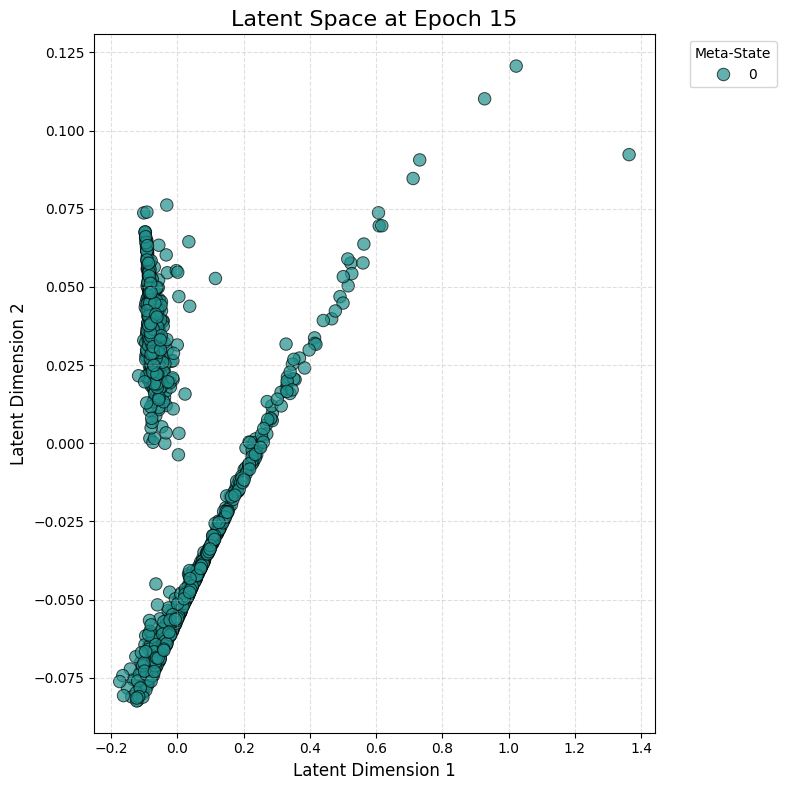

Epoch 20: Loss = 0.1215, LR = 0.000624


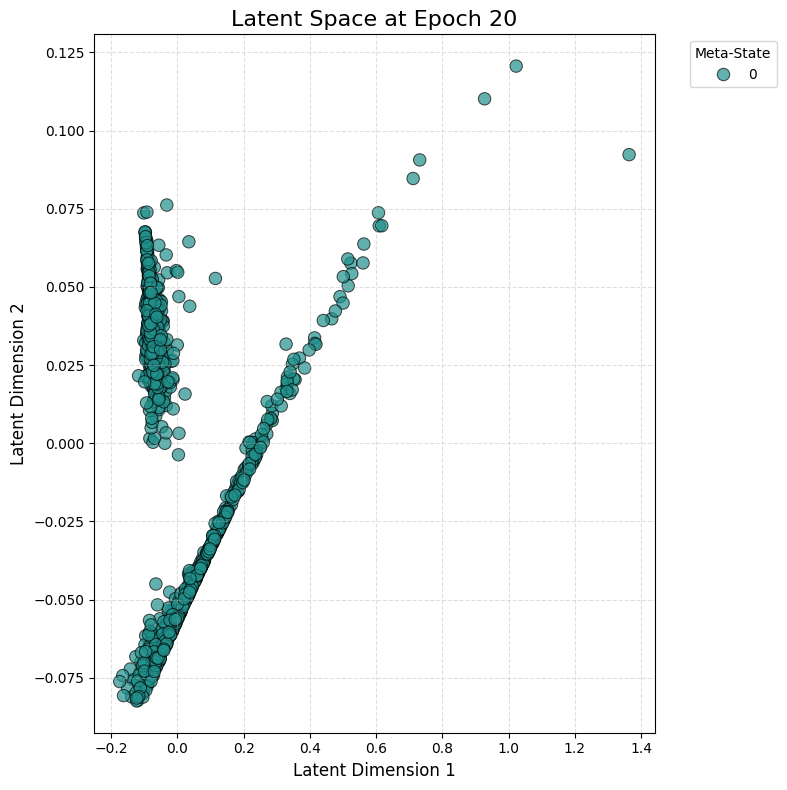

Epoch 25: Loss = 0.1213, LR = 0.000469


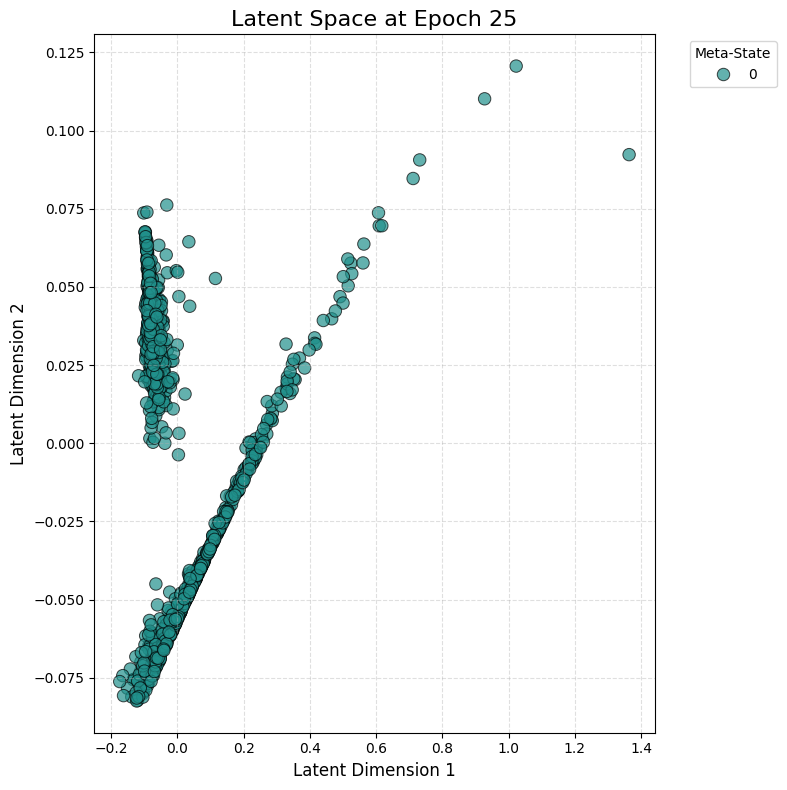

Epoch 30: Loss = 0.1215, LR = 0.000316


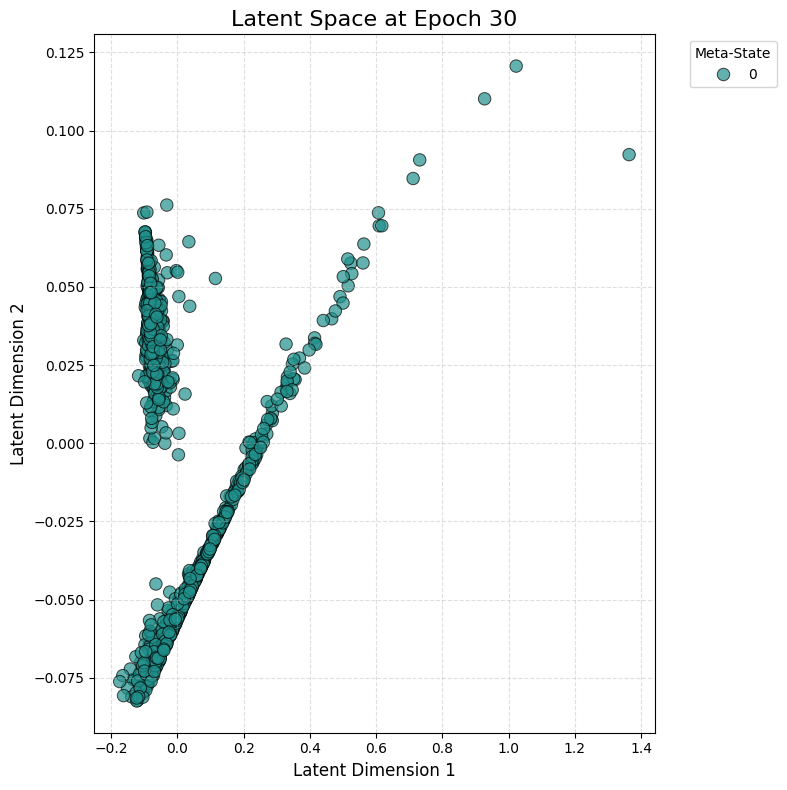

Epoch 35: Loss = 0.1221, LR = 0.000181


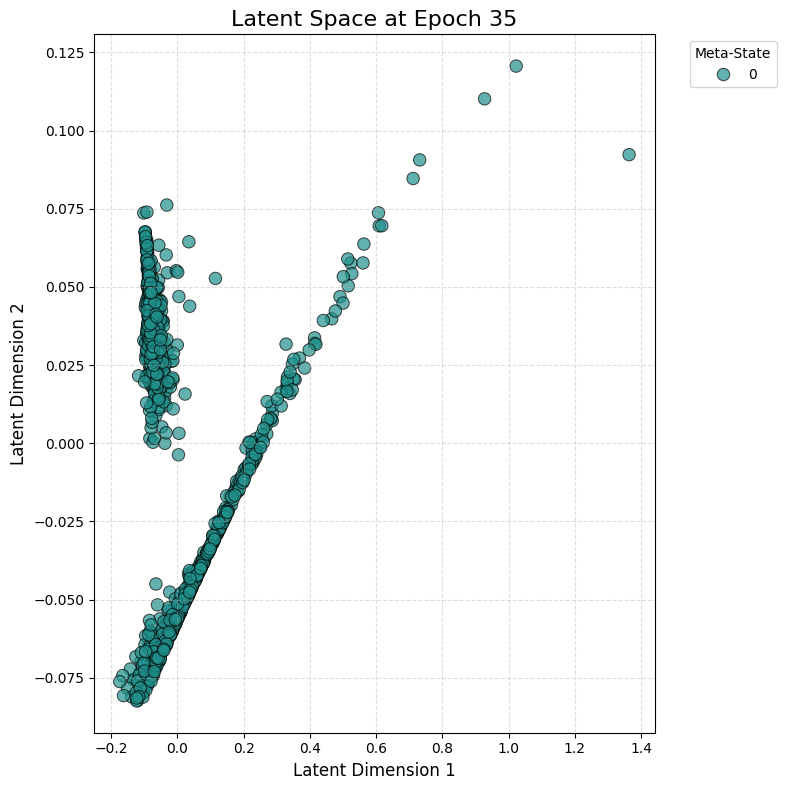

Epoch 40: Loss = 0.1215, LR = 0.000078


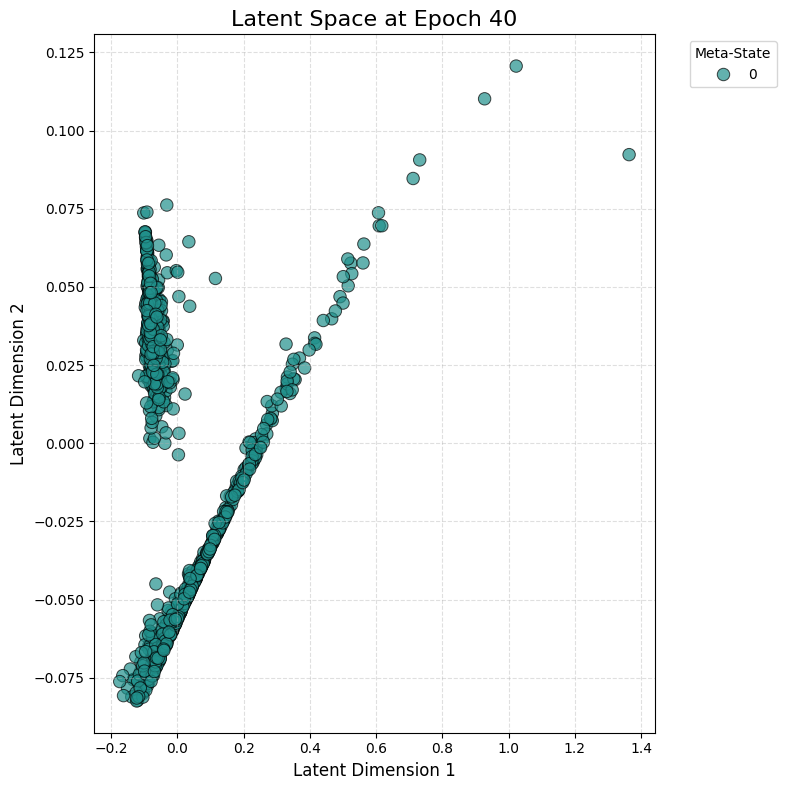

Epoch 45: Loss = 0.1215, LR = 0.000016


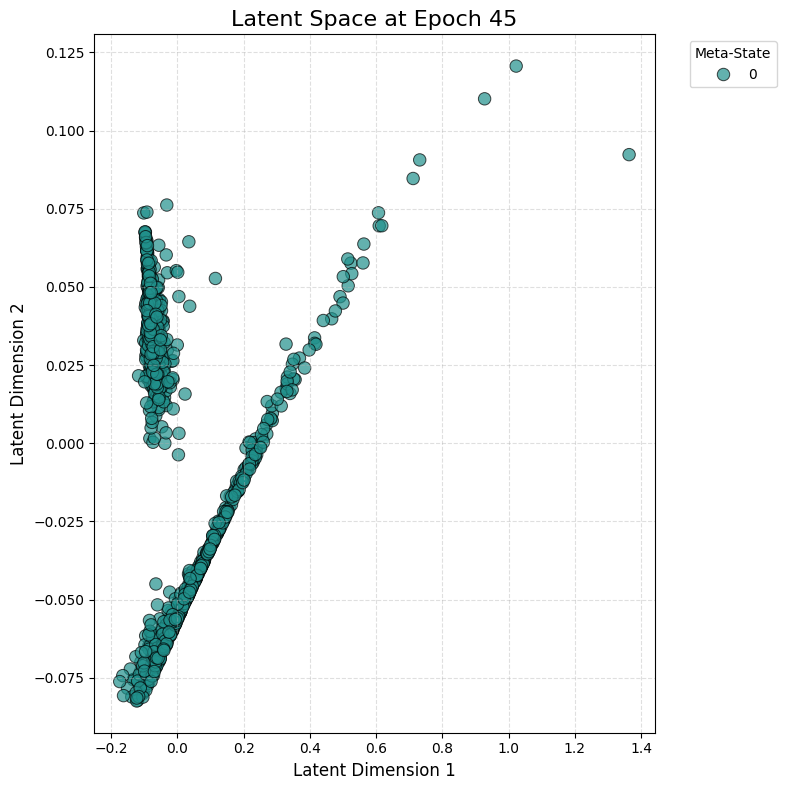

Epoch 49: Loss = 0.1224, LR = 0.000000


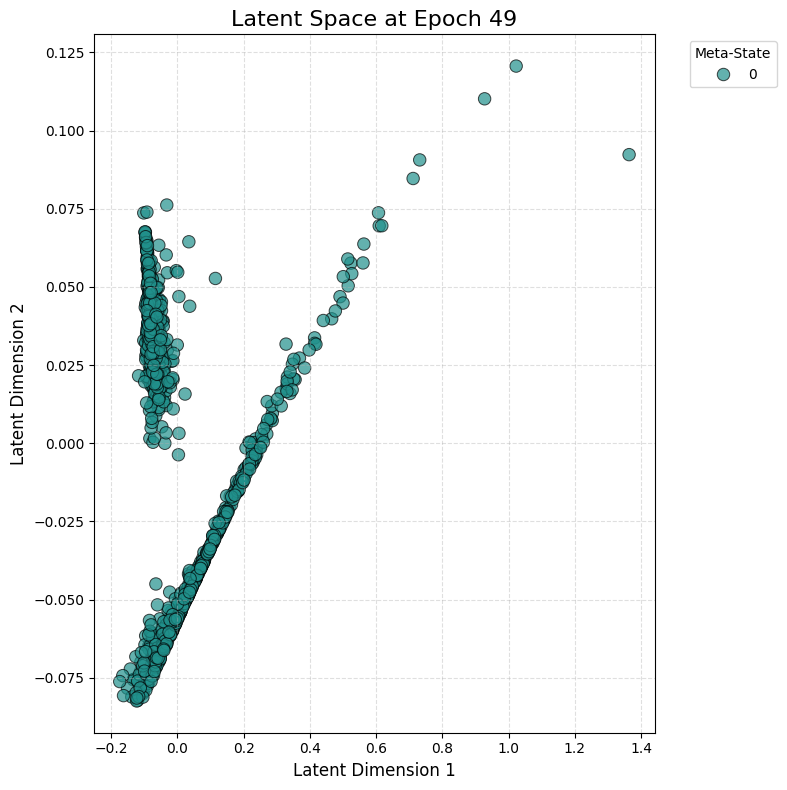

In [7]:
train()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time

# --- Agent Architecture (No changes needed here) ---

class FractalEncoder(nn.Module):
    """Encodes the observed state into a latent representation."""
    def __init__(self, input_dim, latent_dim, num_levels=3):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else latent_dim, latent_dim) for i in range(num_levels)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(latent_dim) for _ in range(num_levels)])

    def forward(self, x):
        for layer, norm in zip(self.layers, self.norms):
            x = F.gelu(norm(layer(x)))
        return x

class MetaStateCodebook(nn.Module):
    """
    Discovers and represents the hidden 'meta-states' (e.g., 'locked', 'unlocked').
    This uses vector quantization as described in the paper.
    """
    def __init__(self, latent_dim, codebook_size):
        super().__init__()
        self.embedding = nn.Parameter(torch.randn(codebook_size, latent_dim))

    def forward(self, z):
        dists = torch.cdist(z, self.embedding)
        indices = dists.argmin(dim=-1)
        codes = self.embedding[indices]
        return codes, indices

class CausalDecoder(nn.Module):
    """
    Predicts the causal subgraph (which causes affect which variables)
    based on the identified meta-state.
    """
    def __init__(self, latent_dim, num_vars):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.GELU(),
            nn.Linear(64, num_vars * num_vars),
            nn.Sigmoid() # Probabilities for each causal link
        )
        self.num_vars = num_vars

    def forward(self, meta_embedding):
        logits = self.decoder(meta_embedding)
        return logits.view(-1, self.num_vars, self.num_vars)

class CuriousCausalAgent(nn.Module):
    """
    The complete agent, combining the encoder, codebook, and decoder.
    This agent actively explores to understand the world's Meta-Causal Graph.
    """
    def __init__(self, obs_dim, latent_dim, num_vars, codebook_size):
        super().__init__()
        self.encoder = FractalEncoder(obs_dim, latent_dim)
        self.codebook = MetaStateCodebook(latent_dim, codebook_size)
        self.decoder = CausalDecoder(latent_dim, num_vars)
        self.num_vars = num_vars

    def forward(self, x):
        """Predicts the causal structure for a given observation."""
        z = self.encoder(x)
        meta_emb, meta_idx = self.codebook(z)
        causal_mask_logits = self.decoder(meta_emb)
        # Return z for calculating commitment loss
        return causal_mask_logits, meta_idx, z, meta_emb

    def get_curiosity_reward(self, obs):
        """
        Calculates the curiosity reward for an observation.
        This is the entropy of the predicted causal mask, encouraging exploration
        of states with high uncertainty.
        """
        mask_logits, _, _, _ = self.forward(obs)
        # Shannon entropy of the posterior distribution over potential causal relationships [cite: 153]
        entropy = -torch.sum(mask_logits * torch.log2(mask_logits.clamp(min=1e-8)), dim=[1, 2])
        return entropy.mean()

    def choose_action(self, env, epsilon=0.1):
        """
        The agent's 'thought process' for deciding what to do next.
        It simulates each action and chooses the one it's most 'curious' about.
        """
        print("\n🤔 Agent's Thought Process...")

        # Epsilon-greedy exploration
        if np.random.rand() < epsilon:
            action = np.random.choice(env.action_space)
            print(f"   - Epsilon={epsilon:.2f}: Decided to explore randomly. Action: {env.action_names[action]}")
            return action

        curiosity_scores = []
        with torch.no_grad():
            for action in range(env.action_space):
                potential_obs = env.peek_action(action)
                potential_obs_tensor = torch.tensor(potential_obs, dtype=torch.float32).unsqueeze(0)
                curiosity = self.get_curiosity_reward(potential_obs_tensor)
                curiosity_scores.append(curiosity.item())
                print(f"   - Considering action '{env.action_names[action]}'... Predicted curiosity score: {curiosity.item():.4f}")

        best_action = np.argmax(curiosity_scores)
        print(f"   - Conclusion: '{env.action_names[best_action]}' is the most informative action to take.")
        return best_action


# --- The Environment: The Door Problem (No changes needed here) ---
class DoorEnvironment:
    """
    A simple simulation of the door problem described in the paper.
    The causal link 'Push -> Open' depends on the meta-state 'Locked'.
    """
    def __init__(self):
        self.num_vars = 2  # Variables: [Is_Open, Is_Locked]
        self.action_space = 3  # Actions: [Push, Unlock, Lock]
        self.action_names = {0: "PUSH_DOOR", 1: "UNLOCK_DOOR", 2: "LOCK_DOOR"}
        self.reset()

    def reset(self):
        """Resets the environment to a random state."""
        self.is_locked = np.random.choice([0.0, 1.0])
        self.is_open = 0.0
        return self.get_observation()

    def get_observation(self):
        """Returns the current state of the environment."""
        return np.array([self.is_open, self.is_locked])

    def peek_action(self, action):
        """See the result of an action without changing the state."""
        temp_is_open, temp_is_locked = self.is_open, self.is_locked
        if action == 0:  # Push
            if not temp_is_locked: temp_is_open = 1.0
        elif action == 1:  # Unlock
            temp_is_locked = 0.0
        elif action == 2:  # Lock
            temp_is_locked = 1.0
        return np.array([temp_is_open, temp_is_locked])


    def step(self, action):
        """
        Applies an action and returns the new observation and the true causal effect.
        An 'intervention' on the environment.
        """
        prev_obs = self.get_observation()

        # Apply action logic
        if action == 0: # Push
            # The causal link between "push" and "open" exists only if the door is unlocked [cite: 49]
            if not self.is_locked: self.is_open = 1.0
        elif action == 1: # Unlock
            self.is_locked = 0.0
        elif action == 2: # Lock
            self.is_locked = 1.0

        next_obs = self.get_observation()

        # Determine the ground-truth causal changes for the loss function
        delta_matrix = np.zeros((self.num_vars, self.num_vars))
        if action == 0 and not prev_obs[1]:
            delta_matrix[0, 0] = 1
        if action == 1:
            delta_matrix[1, 1] = 1
        if action == 2:
            delta_matrix[1, 1] = 1

        return next_obs, torch.tensor(delta_matrix, dtype=torch.float32)

# --- Loss Function (No changes needed here) ---
def causal_loss(mask_logits, delta_matrix, lambda_1=1.0, lambda_2=0.5):
    """
    The loss function encourages the model to predict the correct causal links.
    This is L_mask from the paper[cite: 160].
    """
    positive_loss = -torch.log(mask_logits.clamp(min=1e-8)) * delta_matrix
    negative_loss = -torch.log(1 - mask_logits.clamp(min=1e-8)) * (1 - delta_matrix)
    return (lambda_1 * positive_loss + lambda_2 * negative_loss).mean()

# --- Visualization (No changes needed here) ---
def visualize_causal_graphs(agent):
    """Shows the learned causal graphs for each discovered meta-state."""
    print("\n" + "="*50)
    print("🔬 Visualizing Learned Causal Knowledge")
    print("="*50)
    with torch.no_grad():
        for i in range(agent.codebook.embedding.shape[0]):
            meta_state_emb = agent.codebook.embedding[i].unsqueeze(0)
            causal_mask = agent.decoder(meta_state_emb).squeeze(0)

            print(f"\nLearned Causal Graph for Meta-State {i}:")
            # This matrix M_u[i, j] = 1 indicates that variable i is a parent of variable j [cite: 97]
            print("      Causes -> | Is_Open | Is_Locked")
            print("--------------------------------------")
            print(f"Var 'Is_Open'   |  {causal_mask[0, 0]:.2f}   |  {causal_mask[0, 1]:.2f}")
            print(f"Var 'Is_Locked' |  {causal_mask[1, 0]:.2f}   |  {causal_mask[1, 1]:.2f}")

            # Interpret the learned rules
            if causal_mask[0,0] > 0.8 and causal_mask[1,0] < 0.2:
                 print("   Interpretation: In this state, 'Push' likely causes 'Open'. (Door appears UNLOCKED)")
            elif causal_mask[0,0] < 0.2:
                 print("   Interpretation: In this state, 'Push' likely has NO effect on 'Open'. (Door appears LOCKED)")
            else:
                 print("   Interpretation: The agent is still uncertain about this state.")

# --- The Main Simulation Loop ---
def main():
    # --- Config ---
    # MODIFICATION: Increased training time
    EPISODES = 1000
    STEPS_PER_EPISODE = 10

    # --- Initialization ---
    env = DoorEnvironment()
    agent = CuriousCausalAgent(obs_dim=2, latent_dim=8, num_vars=2, codebook_size=2)
    optimizer = torch.optim.Adam(agent.parameters(), lr=0.001)

    # MODIFICATION: Epsilon decay for exploration strategy
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = (epsilon_start - epsilon_end) / (EPISODES * STEPS_PER_EPISODE)
    epsilon = epsilon_start

    # MODIFICATION: Hyperparameters for new loss components
    commitment_weight = 0.25 # Beta in the paper [cite: 145]
    sparsity_weight = 0.001 # Lambda_sparse in the paper

    print("🚀 Starting Simulation: Curious Agent in the Door Environment")

    for episode in range(EPISODES):
        obs = env.reset()
        print(f"\n--- Episode {episode + 1}/{EPISODES} ---")

        for step in range(STEPS_PER_EPISODE):
            current_obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

            action = agent.choose_action(env, epsilon=epsilon)
            epsilon = max(epsilon_end, epsilon - epsilon_decay) # Decay epsilon

            next_obs, true_delta = env.step(action)
            print(f"Action Taken: {env.action_names[action]}")
            print(f"New State: Is_Open={next_obs[0]}, Is_Locked={next_obs[1]}")

            optimizer.zero_grad()
            predicted_mask_logits, meta_idx, z, meta_emb = agent(current_obs_tensor)

            # --- MODIFICATION: Incorporate all loss components ---
            loss_mask = causal_loss(predicted_mask_logits, true_delta)

            # Commitment Loss (L_quantization) [cite: 145]
            loss_commit = F.mse_loss(z.detach(), meta_emb)

            # Sparsity Loss (L_sparse) [cite: 173]
            loss_sparse = torch.mean(torch.abs(predicted_mask_logits))

            # Total Loss
            total_loss = loss_mask + commitment_weight * loss_commit + sparsity_weight * loss_sparse

            total_loss.backward()
            optimizer.step()

            print(f"Learning Update: Meta-State {meta_idx.item()}. Total Loss: {total_loss.item():.4f} (Mask: {loss_mask.item():.4f}, Commit: {loss_commit.item():.4f})")
            obs = next_obs

        # Periodically visualize the learned graphs to see progress
        if (episode + 1) % 15 == 0:
            visualize_causal_graphs(agent)
            time.sleep(1)

    visualize_causal_graphs(agent)

In [9]:
main()

🚀 Starting Simulation: Curious Agent in the Door Environment

--- Episode 1/1000 ---

🤔 Agent's Thought Process...
   - Epsilon=1.00: Decided to explore randomly. Action: PUSH_DOOR
Action Taken: PUSH_DOOR
New State: Is_Open=1.0, Is_Locked=0.0
Learning Update: Meta-State 0. Total Loss: 0.6844 (Mask: 0.4615, Commit: 0.8900)

🤔 Agent's Thought Process...
   - Epsilon=1.00: Decided to explore randomly. Action: UNLOCK_DOOR
Action Taken: UNLOCK_DOOR
New State: Is_Open=1.0, Is_Locked=0.0
Learning Update: Meta-State 0. Total Loss: 0.6627 (Mask: 0.4069, Commit: 1.0216)

🤔 Agent's Thought Process...
   - Epsilon=1.00: Decided to explore randomly. Action: UNLOCK_DOOR
Action Taken: UNLOCK_DOOR
New State: Is_Open=1.0, Is_Locked=0.0
Learning Update: Meta-State 0. Total Loss: 0.6588 (Mask: 0.4034, Commit: 1.0199)

🤔 Agent's Thought Process...
   - Epsilon=1.00: Decided to explore randomly. Action: LOCK_DOOR
Action Taken: LOCK_DOOR
New State: Is_Open=1.0, Is_Locked=1.0
Learning Update: Meta-State 0. T